# DeepDream

DeepDream is a computer vision program created by Google engineer Alexander Mordvintsev that uses a convolutional neural network to find and enhance patterns in images. Deep dream visualizes patterns learned by neural networks. The neural network examines the picture and begins to transfer the patterns it has learned to the picture. As the image progresses over the network, its gradients are calculated according to the activations. Afterwards, the image is changed to increase activations. In this way, a deep dream is generated. This process was named as "Inceptionism". Name inspiration comes from Christopher Nolan movie "Inception".


Let's start generating a deep dream

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

## Pick an image to dream

Throughout the tutorial, we will be using John William Godward painting called "Sweet Dreams"

In [2]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/John_William_Godward_-_Sweet_Dreams_-_c_1901.jpg/1573px-John_William_Godward_-_Sweet_Dreams_-_c_1901.jpg'

In [3]:
# Get the image and convert into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Apply normalization to an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


Now change the "max_dim" to adjust maximum dimension size. Lower to number makes faster the calculate. We recommend that you start with a low max_dim(400-500) and experience the model then find the dimension that suits your computation power.

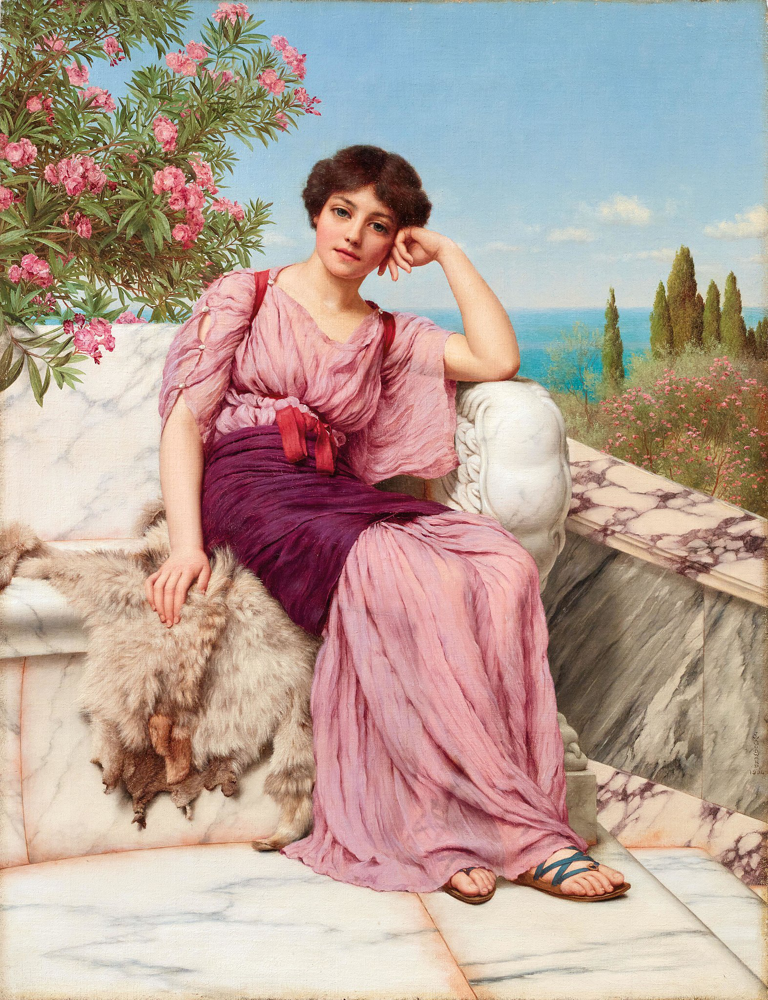

<IPython.core.display.HTML object>

In [4]:
original_img = download(url, max_dim=1000)
show(original_img)
display.display(display.HTML())

## Image classification model

You will use [InceptionV3](https://keras.io/api/applications/inceptionv3/) to generate deep dreams. InceptionV3 is fast so we don't have to wait for a long time to see results. Keep that in mind, any [pre-trained model](https://keras.io/api/applications/#available-models) will work, although you will have to change the layer names below if you want to change the model.

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

The InceptionV3 architecture has a 11 layers. These layers named 'mixed0' though 'mixed10'. Every layer results different sytle of dream-like images. Deeper layers are more complex, while earlier layers are more simple. Higher the level, computation will take longer time.

mixed0 = Wavy(Van Gogh like)

mixed1 = Lines

mixed2 = Circles

mixed3 = Eyes

mixed4 = Faces

mixed5 = Dogs

mixed6 = Gustav Klimt like

mixed7, mixed8, mixed9, mixed10  = Dry Paint Like(7 to 10 results becomes more complex)

You can also combine layers to generate more surrealistic deep dreams. For example ['mixed6', 'mixed10']. 

In [6]:
# Maximize the activations of selected layers
names = ['mixed6']
layers = [base_model.get_layer(name).output for name in names]

# Create the model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. Normalization applied at each layer to prevent larger layers does not outweigh smaller layers. In real life, loss is a number you want to minimize using gradient descent. In DeepDream, the procces is total opposite. You will maximize this loss using gradient ascent.

In [7]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

## Gradient ascent

After calculation of losses, We need to calculate the gradients and put them to the original image. Adding gradients will allow patterns to start forming in the picture.

In [8]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [9]:
deepdream = DeepDream(dream_model)

## Main Loop

In [10]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

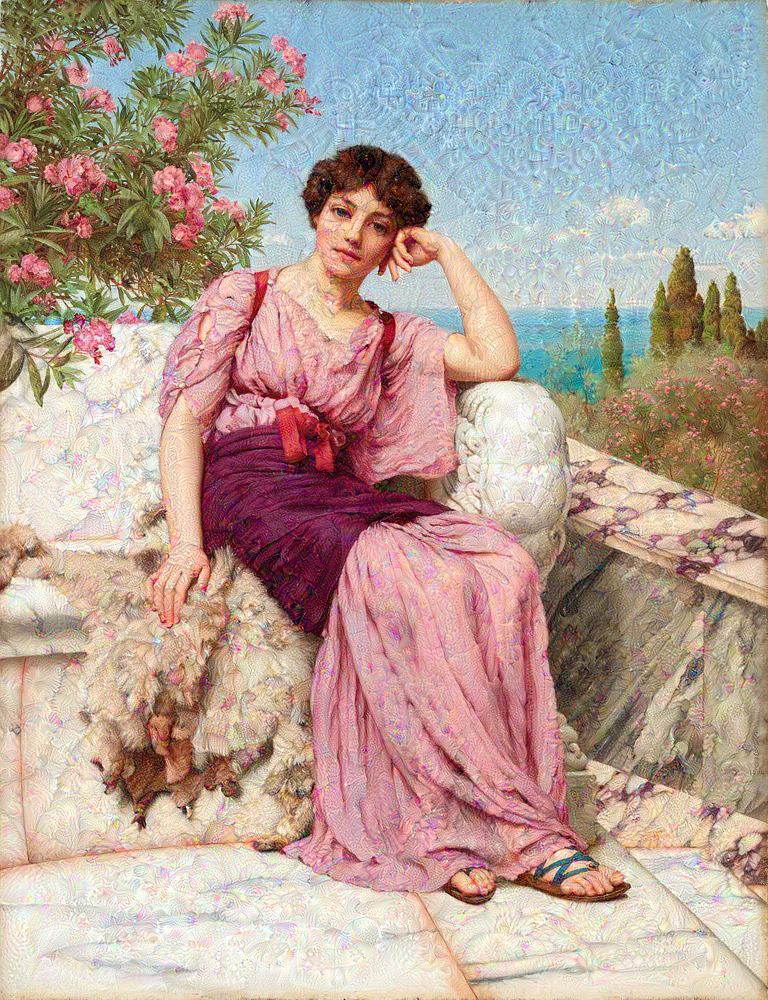

In [11]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

## Scaling up with tiles

When image size increases, gradient calculation time and requirements in memory increases.

We can split the image into tiles and compute the gradient for each tile. Tiles will solve our problem.

We will apply random shifts to the image.


In [12]:
img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

In [13]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

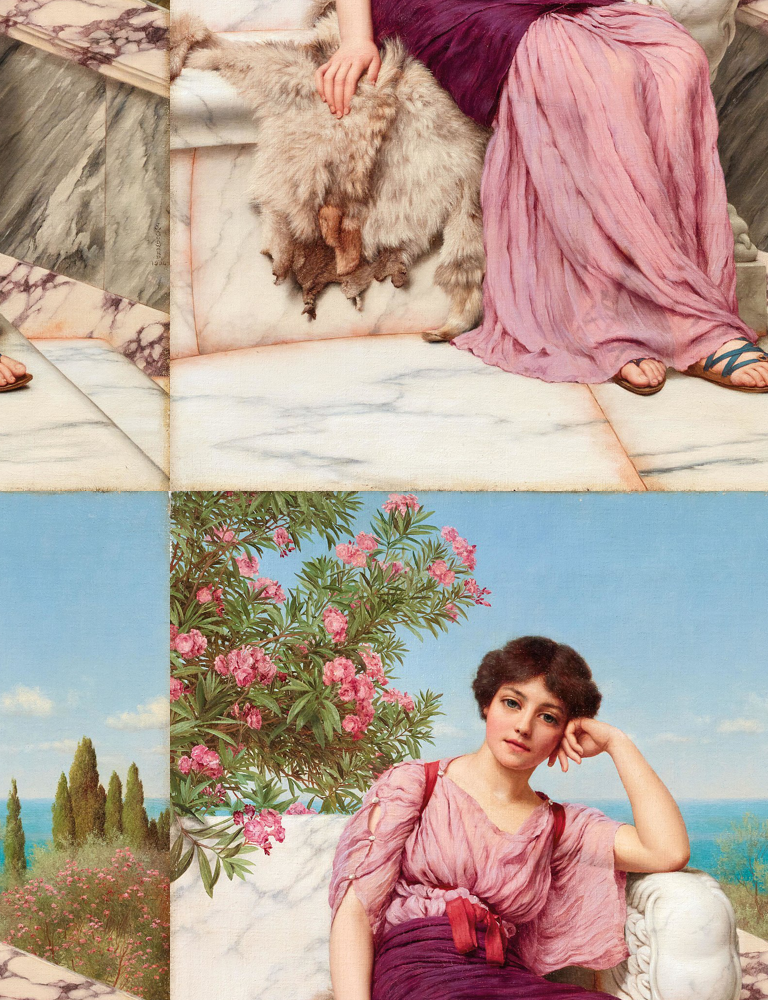

In [14]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

Here is a tiled equivalent of the `deepdream` function defined earlier:

In [15]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [16]:
get_tiled_gradients = TiledGradients(dream_model)

With this function we can select octave counts and steps per octave. Simply we will generate (octave number)*(steps per octave) number of pictures. Pictures saved to selected directory.

In [17]:
import cv2
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(0,5), octave_scale=1.2):
    base_shape = tf.shape(img)
    img = tf.keras.utils.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1] 
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale)
        new_size = tf.cast(new_size, tf.int32)
        img = tf.image.resize(img, new_size)

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img, new_size)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            img2 = np.array(deprocess(img))
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            cv2.imwrite('dream/image{}_{}.png'.format(octave, step+1),img2)

            if step % 10 == 0:
                #display.clear_output(wait=True)
                show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))
                print(initial_shape) 

    result = deprocess(img)
    return result

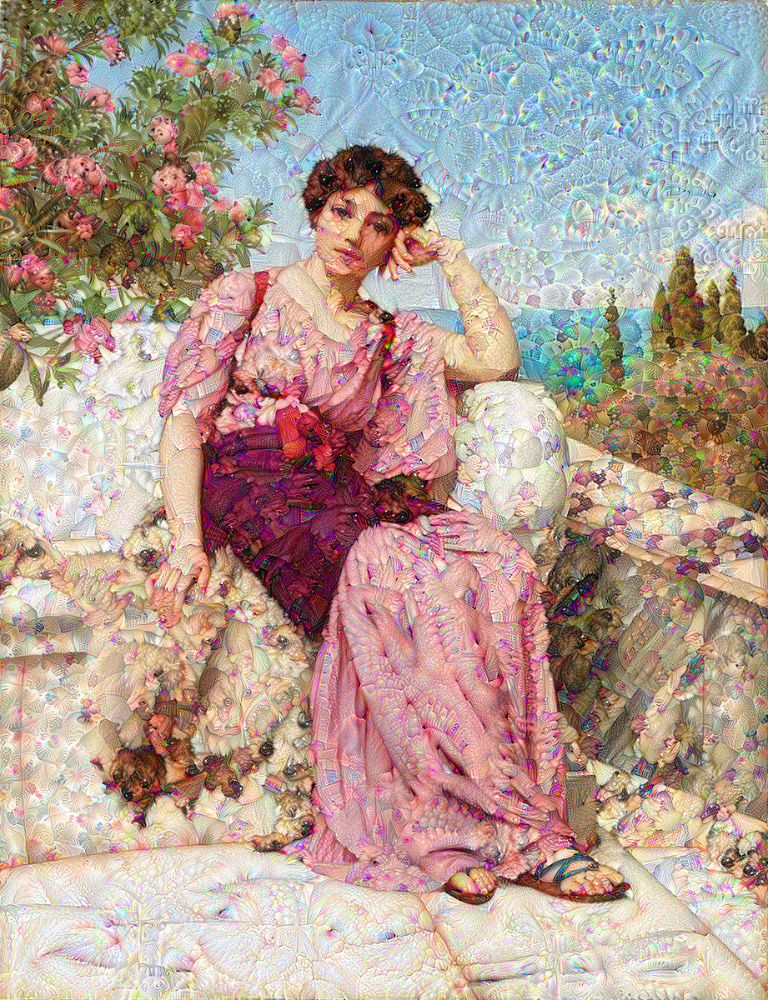

In [18]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

Now we can convert images to video. 

In [19]:
import numpy as np
import glob

img_array = []
for filename in glob.glob('dream/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('deepdream.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()